## **$$
\begin{cases}
  \frac{\partial s(x,t)}{\partial t} -  \frac{\partial^2 s(x,t)}{\partial x^2} = u(x,t) \quad \forall x,t \in [0,1] \times [0,T] \\
  s(0,t)=1 \quad \forall t \in [0,T] \\
  s(L,t)=0 \quad \forall t \in [0,T] \\
  s(x,0)=s_0(t) \quad \forall x \in [0,L] \\
\end{cases}
  $$**

# Imports

In [ ]:
!pip install deepxde
!pip install scikit-optimize
!pip install pathos
import sys
sys.path.insert(1, "/gdrive/My Drive/ScML_Referat/deepxde-0.11.2")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ScML_Referat/Heat_3

Mounted at /gdrive
/gdrive/My Drive/ScML_Referat/Heat_3


# Gaussian Random Spaces

In [ ]:
import deepxde as dde
import skopt
import deepxde112 as dde112
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import clear_output

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Using TensorFlow 2 backend.



In [ ]:
# Generate the GRF function space in 2D
space = dde.data.GRF2D(length_scale=0.1)

# Radomly generate 1 functions u
feature = space.random(1)

# Build struct of sensors iin the right shape
x = np.linspace(0, 1, num=500)
y = np.linspace(0, 1, num=500)
X, Y = np.meshgrid(x, y)
sensors = np.vstack((np.ravel(X), np.ravel(Y))).T

# Evaluate u at the sensors
u = space.eval_batch(feature, sensors)

In [ ]:
print(feature.shape)
print(sensors.shape)
print(u.shape)

(1, 10000)
(250000, 2)
(1, 250000)


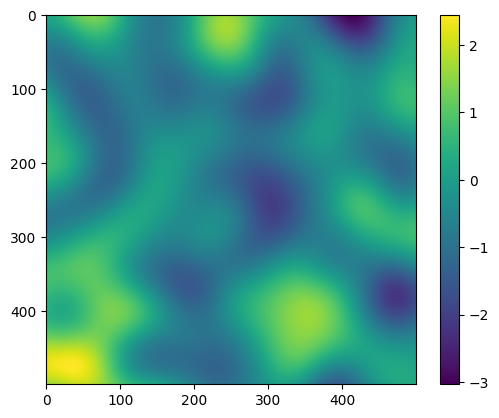

In [ ]:
plt.figure()
u=np.reshape(u, (len(y), len(x)))
plt.imshow(u)
plt.colorbar()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=u)])
fig.show()

# Implement CN for Heat Equation

In [ ]:
from scipy.sparse import diags
from scipy.sparse import eye
from scipy.sparse.linalg import spsolve,cg


def heat_CN(L,N,T,K,c1,c2,f,u0):

    # Compute discretization step both in space and time
    h = 2*L/N
    h_2=h*h
    dt = T/K

    # Initialization vector t
    t = np.linspace(0,T,K+1)
    # Initialization vector x
    x = np.linspace(0,L,N+1)

    # Initialization of solution matrix u
    u = np.zeros((N+1,K+1))
    # Initial condition (IC)
    u[:,0] = u0(x);
    # Boundary conditions (BC)
    u[0,:] = c1(t);
    u[-1,:] = c2(t);


    # Build sparse matrix A
    a= -1 * np.ones(N-2)
    b= 2 * np.ones(N-1)
    c= -1 * np.ones(N-2)
    A = (1/h_2) * ( diags(a, -1) + diags(b, 0) + diags(c, 1) )
    I = eye(N-1);

    # Iterative loop
    for k in range(0,K):
        # Assembly rhs
        F1 = f(x[1:-1],t[k]);   # F1 = f(x[1:-1])
        F2 = f(x[1:-1],t[k+1]); # F2 = f(x[1:-1])


        # Apply corrections to the rhs with BC
        F1[0] = F1[0]+c1(t[k])/h_2;
        F1[-1] = F1[-1]+c2(t[k])/h_2;
        F2[0] = F2[0]+c1(t[k+1])/h_2;
        F2[-1] = F2[-1]+c2(t[k+1])/h_2;

        # Solve the problem
        #u[1:-1,k+1] = spsolve( (I + dt/2*A) , ((I - dt/2*A)@u[1:-1,k] + dt/2*(F1+F2)) );
        u[1:-1, k+1] = cg(I + dt/2 * A, ((I - dt/2 * A) @ u[1:-1, k] + np.squeeze(dt/2 * (F1 + F2))))[0]

    return x,t,u


In [ ]:
# Data
L = np.pi
c1 = lambda t: 1+0*t
c2 = lambda t: 0*t
s0 = lambda x: c2(0)+(c2(0)-c1(0))/L * (x-L)
f = lambda x,t: 2*np.cos(x)*np.exp(-t)
uex = lambda x,t: np.cos(x)*np.exp(t)
N = 100;
T = 20;
K = 100;

# Solve!
x,timesteps,u = heat_CN(L,N,T,K,c1,c2,f,s0)


NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)

for t in range(len(timesteps)):
  ax.plot(x,u[:,t])

# Prepare data for training


Generate TRAIN and VALIDATION (here called TEST) samples

In [ ]:
from random import randrange
from scipy.interpolate import LinearNDInterpolator

def generate_samples(num_u,L,N,T,K,c1,c2,S,P):

  # Prepare structures to hold data
  X_list=[[],[]]
  y_list=[]

  # Randomly generate u
  func_space = dde.data.GRF2D(length_scale=0.1)

  counter=0

  for i in range(num_u):
    feature = func_space.random(1)

    # Evalaute u(x) at sensors
    sensors_x = np.linspace(0, 1, num=S)
    sensors_y = np.linspace(0, 1, num=S)
    X, Y = np.meshgrid(sensors_x, sensors_y)
    sensors = np.vstack((np.ravel(X), np.ravel(Y))).T
    u_evaluated = func_space.eval_batch(feature,sensors)

    # Interpolate u to pass it to solver
    interpolated_u = LinearNDInterpolator(sensors,u_evaluated.reshape(-1, 1))

    # Solve PDE for each u
    x,t,sol = heat_CN(L,N,T,K,c1,c2,interpolated_u,s0)

    # Extract a random point in space-time
    for i in range(P):
      X_list[0].append( u_evaluated )
      random_x_index=randrange(0,N+1)
      random_t_index=randrange(0,K+1)
      X_list[1].append([x[random_x_index],t[random_t_index]])
      y_list.append([sol[random_x_index,random_t_index]])

    counter+=1
    clear_output()
    print(str(counter/num_u*100)+"%")

  X_list[0]=np.squeeze(np.array(X_list[0]))
  X_list[1]=np.array(X_list[1])
  y_list=np.array(y_list[:])

  return (X_list[0],X_list[1]), y_list

In [ ]:
N = 100       # Grid refinement in space   100
K = 100      # Grid refinement in time   100
S = 6       # S*S is Number of sensors        100
P = 100       # Number of sampling points  500
num_u = 100   # Number of functions u      100

In [ ]:
# Generate training samples
X_train, y_train = generate_samples(num_u,L,N,T,K,c1,c2,S,P)
np.savez_compressed("Data_storage/train_data.npz", X_train0=X_train[0], X_train1=X_train[1], y_train=y_train)

# Generate validation samples
X_test, y_test = generate_samples(num_u,L,N,T,K,c1,c2,S,P)
np.savez_compressed("Data_storage/test_data.npz", X_test0=X_test[0], X_test1=X_test[1], y_test=y_test)

NameError: ignored

In [ ]:
# Reload the datapoints
d = np.load("Data_storage/train_data.npz")
X_train, y_train = (d["X_train0"], d["X_train1"]), d["y_train"]
d = np.load("Data_storage/test_data.npz")
X_test, y_test = (d["X_test0"], d["X_test1"]), d["y_test"]

In [ ]:
print("Training samples")
print(X_train[0].shape)
print(X_train[1].shape)
print(y_train.shape)
print("Test samples")
print(X_test[0].shape)
print(X_test[1].shape)
print(y_test.shape)

Training samples
(10000, 36)
(10000, 2)
(10000, 1)
Test samples
(10000, 36)
(10000, 2)
(10000, 1)


Construct object Operator Dataset

In [ ]:
data = dde112.data.OpDataSet(
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)
print(data)

Build the network

In [ ]:
# Hyperparameters
lr = 0.001
epochs = 10000      # originally 50k

# Network
nn = "opnn"
activation = "relu"
initializer = "Glorot normal"  # "He normal" or "Glorot normal"
dim_x = 2

net = dde112.maps.OpNN(
    [S*S, 40, 40],
    [dim_x, 40, 40],
    activation,
    initializer,
    use_bias=True,
    stacked=False,
)

Build the model

In [ ]:
def mean_squared_error_outlier(y_true, y_pred):
    error = np.ravel((y_true - y_pred) ** 2)
    error = np.sort(error)[: -len(error) // 1000]
    return np.mean(error)

model = dde112.Model(data, net)
model.compile("adam", lr=lr, metrics=[mean_squared_error_outlier])
checker = dde.callbacks.ModelCheckpoint(
    "model/model.ckpt", save_better_only=True, period=100
)
#model.print_model()

Compiling model...
Building operator neural network...
'build' took 0.057158 s



/gdrive/My Drive/ScML_Referat/deepxde-0.11.2/deepxde112/maps/opnn.py:183: UserWarning:

`tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.



'compile' took 0.247046 s



Train the model

In [ ]:
losshistory, train_state = model.train(epochs=epochs,print_model=True)

In [ ]:
model.save("Model_storage/small_demonstration",verbose=1)

Epoch 30000: saving model to heat_1_model_100x500-30000 ...

